In [1]:
from __future__ import print_function
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import argparse

Using TensorFlow backend.


In [2]:
from keras import layers, initializers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, LSTM, ConvLSTM2D
from keras.layers.core import Reshape
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11015288014702990426
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9036378610224039075
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [4]:
import os
import sys
sys.path.append("/home/ubuntu/anaconda3/lib/python3.6/site-packages")
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as intp
import sys
import time
from matplotlib import animation, rc
from matplotlib.pyplot import figure
import hdf5storage as h5mat
import h5py as h5
import sklearn.model_selection
import pydot
from matplotlib.pyplot import figure

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [5]:
# directory info
model_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/models/'
model_file = '600x200x10000_flat2.mat'
model_path = model_directory+model_file
shot_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/shots/'
shot_file = '600x200x10000_flat2_1shot.mat'
shot_path=shot_directory+shot_file
filepath=os.getcwd()

In [6]:
# Reading all the shot data
dout = h5.File(shot_path,'r')

# Reading all the velocity models
dout1 = h5.File(model_path,'r')

depth_sample = 10
vel_top = 1500
time_max = 0.8
time_sample = 2e-3
time_interp = np.arange(depth_sample/vel_top, time_max,time_sample)

num_shots = 1000
shot_shape_offset,shot_shape_time  = dout['shot_model_1'].shape
shot_data =  np.zeros((shot_shape_offset,shot_shape_time,num_shots)) #offset, time, samples
vel_rms_data = np.zeros((time_interp.shape[0],num_shots))

for i in range(num_shots):
    shot_data[:,:,i] = dout['shot_model_'+str(i)]
    vp_dummy = dout1['vp'+str(i)]
    vp_dummy = np.transpose(vp_dummy[:,:])
    vp_trace = vp_dummy[:,int(vp_dummy.shape[1]/2)]
    time_diff = depth_sample/vp_trace
    time = np.cumsum(time_diff)
    vp = intp.interp1d(time, vp_trace)(time_interp)
    vel_rms_data[:,i] = np.sqrt(np.cumsum(vp**2)/np.arange(1,vp.shape[0]+1,1))
    
del dout, dout1, vp_dummy, vp_trace, time, vp

print('n_x:',shot_data.shape)
print('n_y:', vel_rms_data.shape)

n_x: (599, 433, 1000)
n_y: (397, 1000)


In [7]:
# Normalize input and output data
shot_data_normalize = (shot_data - np.min(shot_data, axis =(0,1)))/(np.max(shot_data, axis =(0,1))-np.min(shot_data, axis =(0,1)))
vel_rms_data_normalize = (vel_rms_data - np.min(vel_rms_data, axis=0))/(np.max(vel_rms_data, axis=0) - np.min(vel_rms_data, axis=0))

# Reshape
vel_rms_data_normalize = vel_rms_data_normalize.transpose()
shot_data_normalize = np.swapaxes(shot_data_normalize.transpose(),1,2 )

# Split data into train and test set
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(shot_data_normalize,vel_rms_data_normalize, test_size=0.2, random_state=1)

# X_test, X_val, Y_test, Y_val = sklearn.model_selection.train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 800
number of test examples = 200
X_train shape: (800, 599, 433, 1)
Y_train shape: (800, 397)
X_test shape: (200, 599, 433, 1)
Y_test shape: (200, 397)


In [30]:
# Building neural network in Keras 
given_seed = 3 # For repeatibility

def velocitynet_1(input_shape):
    """
    Implementation of the VelocityNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input
    X_input= Input(input_shape)
    X=X_input
   
    # CONV -> BN -> RELU Block applied to X
    
    X = Conv2D(16, (14, 14), strides=(2, 2), name='conv0', 
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    


    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool0')(X)
    X = Dropout(0.3)(X)
    

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Reshape((146,105*16))(X)
    
    X=LSTM(397)(X)
    
    X = Dense(397, activation='sigmoid', name='fc')(X)
    X = Activation('relu')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    
    model = Model(inputs=X_input, outputs=X, name='velModel_1')

    return model
    ### END CODE HERE ###

In [31]:
# Building neural network in Keras 
given_seed = 3 # For repeatibility

def velocitynet_2(input_shape):
    """
    Implementation of the VelocityNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input
    X_input= Input(input_shape)
    X=X_input
   
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (14, 14), strides=(2, 2), name='conv0', 
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    


    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool0')(X)
    X = Dropout(0.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (10, 10), strides=(2, 2), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool1')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)
    

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Reshape((34,768))(X)
    
    X=LSTM(397)(X)
    
    X = Dense(397, activation='sigmoid', name='fc')(X)
    X = Activation('relu')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    
    model = Model(inputs=X_input, outputs=X, name='velModel_2')

    return model
    ### END CODE HERE ###

In [32]:
# Building neural network in Keras 
given_seed = 3 # For repeatibility

def velocitynet_3(input_shape):
    """
    Implementation of the VelocityNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input
    X_input= Input(input_shape)
    X=X_input
   
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (14, 14), strides=(2, 2), name='conv0', 
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    


    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool0')(X)
    X = Dropout(0.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (10, 10), strides=(2, 2), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool1')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (8, 8), strides=(2, 2), name='conv2',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn2')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((8, 8), strides=(4,4),name='max_pool2')(X)
    
    # Adding Dropout
    X = Dropout(0.3)(X)
    

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Reshape((2,64))(X)
    
    X=LSTM(397)(X)
    
    X = Dense(397, activation='sigmoid', name='fc')(X)
    X = Activation('relu')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    
    model = Model(inputs=X_input, outputs=X, name='velModel_3')

    return model
    ### END CODE HERE ###

In [ ]:
velModel = velocitynet_2(X_train.shape[1:])

In [34]:
velModel.summary()


plot_model(velModel)
SVG(model_to_dot(velModel).create(prog='dot', format='svg'))
plot_model(velModel, to_file='./Figures/model_plot_LSTM_2.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 599, 433, 1)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 293, 210, 16)      3152      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 293, 210, 16)      64        
_________________________________________________________________
activation_23 (Activation)   (None, 293, 210, 16)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 146, 105, 16)      0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 146, 105, 16)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 69, 48, 32)        51232     
__________

In [35]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [37]:
# Compile the model with optimization algorithm, loss function
# from keras.utils import multi_gpu_model
# velModel = multi_gpu_model(velModel, gpus=1)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

velModel.compile(loss='mean_squared_error', metrics=['accuracy', 'mse'], optimizer = adam)

In [38]:
history = velModel.fit(X_train, Y_train, validation_split=0.1, epochs=500, batch_size=32)

Train on 720 samples, validate on 80 samples
Epoch 1/500
720/720 [==============================] - 10s 13ms/step - loss: 0.0337 - acc: 0.0875 - mean_squared_error: 0.0337 - val_loss: 0.0077 - val_acc: 0.9375 - val_mean_squared_error: 0.0077
Epoch 2/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0076 - acc: 0.9528 - mean_squared_error: 0.0076 - val_loss: 0.0063 - val_acc: 0.9375 - val_mean_squared_error: 0.0063
Epoch 3/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0068 - acc: 0.9736 - mean_squared_error: 0.0068 - val_loss: 0.0056 - val_acc: 0.9375 - val_mean_squared_error: 0.0056
Epoch 4/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0060 - acc: 0.9736 - mean_squared_error: 0.0060 - val_loss: 0.0046 - val_acc: 0.9375 - val_mean_squared_error: 0.0046
Epoch 5/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0051 - acc: 0.9722 - mean_squared_error: 0.0051 - val_loss: 0.0068 - val_acc: 0.9375 - val_mean_

720/720 [==============================] - 4s 6ms/step - loss: 0.0024 - acc: 0.9736 - mean_squared_error: 0.0024 - val_loss: 0.0510 - val_acc: 0.9375 - val_mean_squared_error: 0.0510
Epoch 43/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0021 - acc: 0.9736 - mean_squared_error: 0.0021 - val_loss: 0.0501 - val_acc: 0.9375 - val_mean_squared_error: 0.0501
Epoch 44/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0022 - acc: 0.9736 - mean_squared_error: 0.0022 - val_loss: 0.0499 - val_acc: 0.9375 - val_mean_squared_error: 0.0499
Epoch 45/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0021 - acc: 0.9736 - mean_squared_error: 0.0021 - val_loss: 0.0501 - val_acc: 0.9375 - val_mean_squared_error: 0.0501
Epoch 46/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0021 - acc: 0.9736 - mean_squared_error: 0.0021 - val_loss: 0.0476 - val_acc: 0.9375 - val_mean_squared_error: 0.0476
Epoch 47/500
720/720 [===========

Epoch 84/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0025 - val_acc: 0.9375 - val_mean_squared_error: 0.0025
Epoch 85/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0023 - val_acc: 0.9375 - val_mean_squared_error: 0.0023
Epoch 86/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0066 - val_acc: 0.9375 - val_mean_squared_error: 0.0066
Epoch 87/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0026 - val_acc: 0.9375 - val_mean_squared_error: 0.0026
Epoch 88/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0053 - val_acc: 0.9375 - val_mean_squared_error: 0.0053
Epoch 89/500
720/720

Epoch 126/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0012 - acc: 0.9736 - mean_squared_error: 0.0012 - val_loss: 0.0091 - val_acc: 0.9375 - val_mean_squared_error: 0.0091
Epoch 127/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0012 - acc: 0.9736 - mean_squared_error: 0.0012 - val_loss: 0.0270 - val_acc: 0.9375 - val_mean_squared_error: 0.0270
Epoch 128/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0013 - acc: 0.9736 - mean_squared_error: 0.0013 - val_loss: 0.0142 - val_acc: 0.9375 - val_mean_squared_error: 0.0142
Epoch 129/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0013 - acc: 0.9736 - mean_squared_error: 0.0013 - val_loss: 0.0245 - val_acc: 0.9375 - val_mean_squared_error: 0.0245
Epoch 130/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0012 - acc: 0.9736 - mean_squared_error: 0.0012 - val_loss: 0.0100 - val_acc: 0.9375 - val_mean_squared_error: 0.0100
Epoch 131/500
7

720/720 [==============================] - 4s 6ms/step - loss: 9.8521e-04 - acc: 0.9736 - mean_squared_error: 9.8521e-04 - val_loss: 0.0127 - val_acc: 0.9375 - val_mean_squared_error: 0.0127
Epoch 168/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0011 - acc: 0.9736 - mean_squared_error: 0.0011 - val_loss: 0.0067 - val_acc: 0.9375 - val_mean_squared_error: 0.0067
Epoch 169/500
720/720 [==============================] - 4s 6ms/step - loss: 9.7483e-04 - acc: 0.9736 - mean_squared_error: 9.7483e-04 - val_loss: 0.0137 - val_acc: 0.9375 - val_mean_squared_error: 0.0137
Epoch 170/500
720/720 [==============================] - 4s 6ms/step - loss: 9.5660e-04 - acc: 0.9736 - mean_squared_error: 9.5660e-04 - val_loss: 0.0133 - val_acc: 0.9375 - val_mean_squared_error: 0.0133
Epoch 171/500
720/720 [==============================] - 4s 6ms/step - loss: 9.8470e-04 - acc: 0.9736 - mean_squared_error: 9.8470e-04 - val_loss: 0.0188 - val_acc: 0.9375 - val_mean_squared_error: 0.01

720/720 [==============================] - 4s 6ms/step - loss: 8.4209e-04 - acc: 0.9736 - mean_squared_error: 8.4209e-04 - val_loss: 0.0073 - val_acc: 0.9375 - val_mean_squared_error: 0.0073
Epoch 208/500
720/720 [==============================] - 4s 6ms/step - loss: 7.9266e-04 - acc: 0.9736 - mean_squared_error: 7.9266e-04 - val_loss: 0.0057 - val_acc: 0.9375 - val_mean_squared_error: 0.0057
Epoch 209/500
720/720 [==============================] - 4s 6ms/step - loss: 7.9603e-04 - acc: 0.9736 - mean_squared_error: 7.9603e-04 - val_loss: 0.0043 - val_acc: 0.9375 - val_mean_squared_error: 0.0043
Epoch 210/500
720/720 [==============================] - 4s 6ms/step - loss: 7.9204e-04 - acc: 0.9736 - mean_squared_error: 7.9204e-04 - val_loss: 0.0048 - val_acc: 0.9375 - val_mean_squared_error: 0.0048
Epoch 211/500
720/720 [==============================] - 4s 6ms/step - loss: 7.8108e-04 - acc: 0.9736 - mean_squared_error: 7.8108e-04 - val_loss: 0.0042 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 6.7276e-04 - acc: 0.9736 - mean_squared_error: 6.7276e-04 - val_loss: 0.0065 - val_acc: 0.9375 - val_mean_squared_error: 0.0065
Epoch 248/500
720/720 [==============================] - 4s 6ms/step - loss: 6.6697e-04 - acc: 0.9736 - mean_squared_error: 6.6697e-04 - val_loss: 0.0112 - val_acc: 0.9375 - val_mean_squared_error: 0.0112
Epoch 249/500
720/720 [==============================] - 4s 6ms/step - loss: 6.8455e-04 - acc: 0.9736 - mean_squared_error: 6.8455e-04 - val_loss: 0.0081 - val_acc: 0.9375 - val_mean_squared_error: 0.0081
Epoch 250/500
720/720 [==============================] - 4s 6ms/step - loss: 6.5876e-04 - acc: 0.9736 - mean_squared_error: 6.5876e-04 - val_loss: 0.0094 - val_acc: 0.9375 - val_mean_squared_error: 0.0094
Epoch 251/500
720/720 [==============================] - 4s 6ms/step - loss: 6.6809e-04 - acc: 0.9736 - mean_squared_error: 6.6809e-04 - val_loss: 0.0079 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 6.0551e-04 - acc: 0.9736 - mean_squared_error: 6.0551e-04 - val_loss: 0.0043 - val_acc: 0.9375 - val_mean_squared_error: 0.0043
Epoch 288/500
720/720 [==============================] - 4s 6ms/step - loss: 6.0890e-04 - acc: 0.9736 - mean_squared_error: 6.0890e-04 - val_loss: 0.0028 - val_acc: 0.9375 - val_mean_squared_error: 0.0028
Epoch 289/500
720/720 [==============================] - 4s 6ms/step - loss: 6.0995e-04 - acc: 0.9736 - mean_squared_error: 6.0995e-04 - val_loss: 0.0033 - val_acc: 0.9375 - val_mean_squared_error: 0.0033
Epoch 290/500
720/720 [==============================] - 4s 6ms/step - loss: 5.8779e-04 - acc: 0.9736 - mean_squared_error: 5.8779e-04 - val_loss: 0.0029 - val_acc: 0.9375 - val_mean_squared_error: 0.0029
Epoch 291/500
720/720 [==============================] - 4s 6ms/step - loss: 6.4249e-04 - acc: 0.9736 - mean_squared_error: 6.4249e-04 - val_loss: 0.0033 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 5.3431e-04 - acc: 0.9736 - mean_squared_error: 5.3431e-04 - val_loss: 0.0058 - val_acc: 0.9375 - val_mean_squared_error: 0.0058
Epoch 328/500
720/720 [==============================] - 4s 6ms/step - loss: 5.2133e-04 - acc: 0.9736 - mean_squared_error: 5.2133e-04 - val_loss: 0.0097 - val_acc: 0.9375 - val_mean_squared_error: 0.0097
Epoch 329/500
720/720 [==============================] - 4s 6ms/step - loss: 5.1804e-04 - acc: 0.9736 - mean_squared_error: 5.1804e-04 - val_loss: 0.0075 - val_acc: 0.9375 - val_mean_squared_error: 0.0075
Epoch 330/500
720/720 [==============================] - 4s 6ms/step - loss: 5.3306e-04 - acc: 0.9736 - mean_squared_error: 5.3306e-04 - val_loss: 0.0080 - val_acc: 0.9375 - val_mean_squared_error: 0.0080
Epoch 331/500
720/720 [==============================] - 4s 6ms/step - loss: 5.1373e-04 - acc: 0.9736 - mean_squared_error: 5.1373e-04 - val_loss: 0.0063 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 4.7078e-04 - acc: 0.9736 - mean_squared_error: 4.7078e-04 - val_loss: 0.0042 - val_acc: 0.9375 - val_mean_squared_error: 0.0042
Epoch 368/500
720/720 [==============================] - 4s 6ms/step - loss: 4.9980e-04 - acc: 0.9736 - mean_squared_error: 4.9980e-04 - val_loss: 0.0030 - val_acc: 0.9375 - val_mean_squared_error: 0.0030
Epoch 369/500
720/720 [==============================] - 4s 6ms/step - loss: 4.8554e-04 - acc: 0.9736 - mean_squared_error: 4.8554e-04 - val_loss: 0.0037 - val_acc: 0.9375 - val_mean_squared_error: 0.0037
Epoch 370/500
720/720 [==============================] - 4s 6ms/step - loss: 4.4097e-04 - acc: 0.9736 - mean_squared_error: 4.4097e-04 - val_loss: 0.0035 - val_acc: 0.9375 - val_mean_squared_error: 0.0035
Epoch 371/500
720/720 [==============================] - 4s 6ms/step - loss: 4.7431e-04 - acc: 0.9736 - mean_squared_error: 4.7431e-04 - val_loss: 0.0022 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 4.3669e-04 - acc: 0.9736 - mean_squared_error: 4.3669e-04 - val_loss: 0.0078 - val_acc: 0.9375 - val_mean_squared_error: 0.0078
Epoch 408/500
720/720 [==============================] - 4s 6ms/step - loss: 4.2130e-04 - acc: 0.9736 - mean_squared_error: 4.2130e-04 - val_loss: 0.0062 - val_acc: 0.9375 - val_mean_squared_error: 0.0062
Epoch 409/500
720/720 [==============================] - 4s 6ms/step - loss: 4.2891e-04 - acc: 0.9736 - mean_squared_error: 4.2891e-04 - val_loss: 0.0056 - val_acc: 0.9375 - val_mean_squared_error: 0.0056
Epoch 410/500
720/720 [==============================] - 4s 6ms/step - loss: 4.1760e-04 - acc: 0.9736 - mean_squared_error: 4.1760e-04 - val_loss: 0.0085 - val_acc: 0.9375 - val_mean_squared_error: 0.0085
Epoch 411/500
720/720 [==============================] - 4s 6ms/step - loss: 4.2012e-04 - acc: 0.9736 - mean_squared_error: 4.2012e-04 - val_loss: 0.0081 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 3.8001e-04 - acc: 0.9736 - mean_squared_error: 3.8001e-04 - val_loss: 0.0089 - val_acc: 0.9375 - val_mean_squared_error: 0.0089
Epoch 448/500
720/720 [==============================] - 4s 6ms/step - loss: 4.2144e-04 - acc: 0.9736 - mean_squared_error: 4.2144e-04 - val_loss: 0.0026 - val_acc: 0.9375 - val_mean_squared_error: 0.0026
Epoch 449/500
720/720 [==============================] - 4s 6ms/step - loss: 3.9110e-04 - acc: 0.9736 - mean_squared_error: 3.9110e-04 - val_loss: 0.0031 - val_acc: 0.9375 - val_mean_squared_error: 0.0031
Epoch 450/500
720/720 [==============================] - 4s 6ms/step - loss: 3.8634e-04 - acc: 0.9736 - mean_squared_error: 3.8634e-04 - val_loss: 0.0037 - val_acc: 0.9375 - val_mean_squared_error: 0.0037
Epoch 451/500
720/720 [==============================] - 4s 6ms/step - loss: 3.7607e-04 - acc: 0.9736 - mean_squared_error: 3.7607e-04 - val_loss: 0.0031 - val_acc: 0.9375 - val_mean_squared_err

720/720 [==============================] - 4s 6ms/step - loss: 3.6595e-04 - acc: 0.9736 - mean_squared_error: 3.6595e-04 - val_loss: 0.0061 - val_acc: 0.9375 - val_mean_squared_error: 0.0061
Epoch 488/500
720/720 [==============================] - 4s 6ms/step - loss: 3.5330e-04 - acc: 0.9736 - mean_squared_error: 3.5330e-04 - val_loss: 0.0054 - val_acc: 0.9375 - val_mean_squared_error: 0.0054
Epoch 489/500
720/720 [==============================] - 4s 6ms/step - loss: 3.5988e-04 - acc: 0.9736 - mean_squared_error: 3.5988e-04 - val_loss: 0.0034 - val_acc: 0.9375 - val_mean_squared_error: 0.0034
Epoch 490/500
720/720 [==============================] - 4s 6ms/step - loss: 3.6179e-04 - acc: 0.9736 - mean_squared_error: 3.6179e-04 - val_loss: 0.0032 - val_acc: 0.9375 - val_mean_squared_error: 0.0032
Epoch 491/500
720/720 [==============================] - 4s 6ms/step - loss: 3.6034e-04 - acc: 0.9736 - mean_squared_error: 3.6034e-04 - val_loss: 0.0034 - val_acc: 0.9375 - val_mean_squared_err

In [39]:
velModel = velocitynet_3(X_train.shape[1:])
velModel.compile(loss='mean_squared_error', metrics=['accuracy', 'mse'], optimizer = adam)

In [40]:
history2 = velModel.fit(X_train, Y_train, validation_split=0.1, epochs=500, batch_size=32)

Train on 720 samples, validate on 80 samples
Epoch 1/500
720/720 [==============================] - 6s 8ms/step - loss: 0.0209 - acc: 0.0056 - mean_squared_error: 0.0209 - val_loss: 0.0083 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0083
Epoch 2/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0086 - acc: 0.0014 - mean_squared_error: 0.0086 - val_loss: 0.0070 - val_acc: 0.0125 - val_mean_squared_error: 0.0070
Epoch 3/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0076 - acc: 0.0014 - mean_squared_error: 0.0076 - val_loss: 0.0067 - val_acc: 0.0125 - val_mean_squared_error: 0.0067
Epoch 4/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0067 - acc: 0.0014 - mean_squared_error: 0.0067 - val_loss: 0.0058 - val_acc: 0.0125 - val_mean_squared_error: 0.0058
Epoch 5/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0058 - acc: 0.0014 - mean_squared_error: 0.0058 - val_loss: 0.0087 - val_acc: 0.0125 - val_mea

720/720 [==============================] - 4s 6ms/step - loss: 0.0023 - acc: 0.0014 - mean_squared_error: 0.0023 - val_loss: 0.0035 - val_acc: 0.0125 - val_mean_squared_error: 0.0035
Epoch 43/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0023 - acc: 0.0014 - mean_squared_error: 0.0023 - val_loss: 0.0028 - val_acc: 0.0125 - val_mean_squared_error: 0.0028
Epoch 44/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0023 - acc: 0.0014 - mean_squared_error: 0.0023 - val_loss: 0.0044 - val_acc: 0.0125 - val_mean_squared_error: 0.0044
Epoch 45/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0021 - acc: 0.0014 - mean_squared_error: 0.0021 - val_loss: 0.0194 - val_acc: 0.0125 - val_mean_squared_error: 0.0194
Epoch 46/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0022 - acc: 0.0014 - mean_squared_error: 0.0022 - val_loss: 0.0125 - val_acc: 0.0125 - val_mean_squared_error: 0.0125
Epoch 47/500
720/720 [===========

Epoch 84/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0017 - acc: 0.0014 - mean_squared_error: 0.0017 - val_loss: 0.0047 - val_acc: 0.0125 - val_mean_squared_error: 0.0047
Epoch 85/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0017 - acc: 0.0014 - mean_squared_error: 0.0017 - val_loss: 0.0058 - val_acc: 0.0125 - val_mean_squared_error: 0.0058
Epoch 86/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0018 - acc: 0.0014 - mean_squared_error: 0.0018 - val_loss: 0.0064 - val_acc: 0.0125 - val_mean_squared_error: 0.0064
Epoch 87/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0017 - acc: 0.0014 - mean_squared_error: 0.0017 - val_loss: 0.0092 - val_acc: 0.0125 - val_mean_squared_error: 0.0092
Epoch 88/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0017 - acc: 0.0014 - mean_squared_error: 0.0017 - val_loss: 0.0094 - val_acc: 0.0125 - val_mean_squared_error: 0.0094
Epoch 89/500
720/720

Epoch 126/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0072 - val_acc: 0.0125 - val_mean_squared_error: 0.0072
Epoch 127/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0055 - val_acc: 0.0125 - val_mean_squared_error: 0.0055
Epoch 128/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0087 - val_acc: 0.0125 - val_mean_squared_error: 0.0087
Epoch 129/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0054 - val_acc: 0.0125 - val_mean_squared_error: 0.0054
Epoch 130/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0015 - acc: 0.0014 - mean_squared_error: 0.0015 - val_loss: 0.0198 - val_acc: 0.0125 - val_mean_squared_error: 0.0198
Epoch 131/500
7

720/720 [==============================] - 4s 6ms/step - loss: 0.0012 - acc: 0.0014 - mean_squared_error: 0.0012 - val_loss: 0.0192 - val_acc: 0.0125 - val_mean_squared_error: 0.0192
Epoch 168/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0012 - acc: 0.0014 - mean_squared_error: 0.0012 - val_loss: 0.0169 - val_acc: 0.0125 - val_mean_squared_error: 0.0169
Epoch 169/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0014 - acc: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0111 - val_acc: 0.0125 - val_mean_squared_error: 0.0111
Epoch 170/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0013 - acc: 0.0014 - mean_squared_error: 0.0013 - val_loss: 0.0089 - val_acc: 0.0125 - val_mean_squared_error: 0.0089
Epoch 171/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0013 - acc: 0.0014 - mean_squared_error: 0.0013 - val_loss: 0.0037 - val_acc: 0.0125 - val_mean_squared_error: 0.0037
Epoch 172/500
720/720 [======

720/720 [==============================] - 4s 6ms/step - loss: 0.0010 - acc: 0.3681 - mean_squared_error: 0.0010 - val_loss: 0.0059 - val_acc: 0.2375 - val_mean_squared_error: 0.0059
Epoch 209/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0011 - acc: 0.4569 - mean_squared_error: 0.0011 - val_loss: 0.0040 - val_acc: 0.4125 - val_mean_squared_error: 0.0040
Epoch 210/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0011 - acc: 0.4722 - mean_squared_error: 0.0011 - val_loss: 0.0037 - val_acc: 0.6250 - val_mean_squared_error: 0.0037
Epoch 211/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0010 - acc: 0.5542 - mean_squared_error: 0.0010 - val_loss: 0.0045 - val_acc: 0.6000 - val_mean_squared_error: 0.0045
Epoch 212/500
720/720 [==============================] - 4s 6ms/step - loss: 0.0010 - acc: 0.6153 - mean_squared_error: 0.0010 - val_loss: 0.0057 - val_acc: 0.7000 - val_mean_squared_error: 0.0057
Epoch 213/500
720/720 [======

Epoch 249/500
720/720 [==============================] - 4s 6ms/step - loss: 9.2470e-04 - acc: 0.9736 - mean_squared_error: 9.2470e-04 - val_loss: 0.0032 - val_acc: 0.9375 - val_mean_squared_error: 0.0032
Epoch 250/500
720/720 [==============================] - 4s 6ms/step - loss: 9.5334e-04 - acc: 0.9736 - mean_squared_error: 9.5334e-04 - val_loss: 0.0029 - val_acc: 0.9375 - val_mean_squared_error: 0.0029
Epoch 251/500
720/720 [==============================] - 4s 6ms/step - loss: 9.1282e-04 - acc: 0.9736 - mean_squared_error: 9.1282e-04 - val_loss: 0.0027 - val_acc: 0.9375 - val_mean_squared_error: 0.0027
Epoch 252/500
720/720 [==============================] - 4s 6ms/step - loss: 9.3550e-04 - acc: 0.9736 - mean_squared_error: 9.3550e-04 - val_loss: 0.0040 - val_acc: 0.9375 - val_mean_squared_error: 0.0040
Epoch 253/500
720/720 [==============================] - 4s 6ms/step - loss: 8.3667e-04 - acc: 0.9736 - mean_squared_error: 8.3667e-04 - val_loss: 0.0022 - val_acc: 0.9375 - val_me

Epoch 289/500
720/720 [==============================] - 4s 6ms/step - loss: 7.9413e-04 - acc: 0.9736 - mean_squared_error: 7.9413e-04 - val_loss: 0.0018 - val_acc: 0.9375 - val_mean_squared_error: 0.0018
Epoch 290/500
720/720 [==============================] - 4s 6ms/step - loss: 8.1517e-04 - acc: 0.9736 - mean_squared_error: 8.1517e-04 - val_loss: 0.0019 - val_acc: 0.9375 - val_mean_squared_error: 0.0019
Epoch 291/500
720/720 [==============================] - 4s 6ms/step - loss: 7.9826e-04 - acc: 0.9736 - mean_squared_error: 7.9826e-04 - val_loss: 0.0023 - val_acc: 0.9375 - val_mean_squared_error: 0.0023
Epoch 292/500
720/720 [==============================] - 4s 6ms/step - loss: 7.8424e-04 - acc: 0.9736 - mean_squared_error: 7.8424e-04 - val_loss: 0.0025 - val_acc: 0.9375 - val_mean_squared_error: 0.0025
Epoch 293/500
720/720 [==============================] - 4s 6ms/step - loss: 7.6736e-04 - acc: 0.9736 - mean_squared_error: 7.6736e-04 - val_loss: 0.0022 - val_acc: 0.9375 - val_me

Epoch 329/500
720/720 [==============================] - 4s 6ms/step - loss: 7.1287e-04 - acc: 0.9736 - mean_squared_error: 7.1287e-04 - val_loss: 0.0054 - val_acc: 0.9375 - val_mean_squared_error: 0.0054
Epoch 330/500
720/720 [==============================] - 4s 6ms/step - loss: 7.1145e-04 - acc: 0.9736 - mean_squared_error: 7.1145e-04 - val_loss: 0.0055 - val_acc: 0.9375 - val_mean_squared_error: 0.0055
Epoch 331/500
720/720 [==============================] - 4s 6ms/step - loss: 6.7499e-04 - acc: 0.9736 - mean_squared_error: 6.7499e-04 - val_loss: 0.0027 - val_acc: 0.9375 - val_mean_squared_error: 0.0027
Epoch 332/500
720/720 [==============================] - 4s 6ms/step - loss: 7.0130e-04 - acc: 0.9736 - mean_squared_error: 7.0130e-04 - val_loss: 0.0028 - val_acc: 0.9375 - val_mean_squared_error: 0.0028
Epoch 333/500
720/720 [==============================] - 4s 6ms/step - loss: 6.7059e-04 - acc: 0.9736 - mean_squared_error: 6.7059e-04 - val_loss: 0.0025 - val_acc: 0.9375 - val_me

Epoch 369/500
720/720 [==============================] - 4s 6ms/step - loss: 6.7045e-04 - acc: 0.9736 - mean_squared_error: 6.7045e-04 - val_loss: 0.0047 - val_acc: 0.9375 - val_mean_squared_error: 0.0047
Epoch 370/500
720/720 [==============================] - 4s 6ms/step - loss: 6.2509e-04 - acc: 0.9736 - mean_squared_error: 6.2509e-04 - val_loss: 0.0049 - val_acc: 0.9375 - val_mean_squared_error: 0.0049
Epoch 371/500
720/720 [==============================] - 4s 6ms/step - loss: 6.4439e-04 - acc: 0.9736 - mean_squared_error: 6.4439e-04 - val_loss: 0.0069 - val_acc: 0.9375 - val_mean_squared_error: 0.0069
Epoch 372/500
720/720 [==============================] - 4s 6ms/step - loss: 6.3828e-04 - acc: 0.9736 - mean_squared_error: 6.3828e-04 - val_loss: 0.0040 - val_acc: 0.9375 - val_mean_squared_error: 0.0040
Epoch 373/500
720/720 [==============================] - 4s 6ms/step - loss: 6.6080e-04 - acc: 0.9736 - mean_squared_error: 6.6080e-04 - val_loss: 0.0035 - val_acc: 0.9375 - val_me

Epoch 409/500
720/720 [==============================] - 4s 6ms/step - loss: 6.0688e-04 - acc: 0.9736 - mean_squared_error: 6.0688e-04 - val_loss: 0.0023 - val_acc: 0.9375 - val_mean_squared_error: 0.0023
Epoch 410/500
720/720 [==============================] - 4s 6ms/step - loss: 5.8900e-04 - acc: 0.9736 - mean_squared_error: 5.8900e-04 - val_loss: 0.0032 - val_acc: 0.9375 - val_mean_squared_error: 0.0032
Epoch 411/500
720/720 [==============================] - 4s 6ms/step - loss: 5.6658e-04 - acc: 0.9736 - mean_squared_error: 5.6658e-04 - val_loss: 0.0030 - val_acc: 0.9375 - val_mean_squared_error: 0.0030
Epoch 412/500
720/720 [==============================] - 4s 6ms/step - loss: 5.9909e-04 - acc: 0.9736 - mean_squared_error: 5.9909e-04 - val_loss: 0.0032 - val_acc: 0.9375 - val_mean_squared_error: 0.0032
Epoch 413/500
720/720 [==============================] - 4s 6ms/step - loss: 5.6622e-04 - acc: 0.9736 - mean_squared_error: 5.6622e-04 - val_loss: 0.0029 - val_acc: 0.9375 - val_me

Epoch 449/500
720/720 [==============================] - 4s 6ms/step - loss: 5.5842e-04 - acc: 0.9736 - mean_squared_error: 5.5842e-04 - val_loss: 0.0025 - val_acc: 0.9375 - val_mean_squared_error: 0.0025
Epoch 450/500
720/720 [==============================] - 4s 6ms/step - loss: 4.9942e-04 - acc: 0.9736 - mean_squared_error: 4.9942e-04 - val_loss: 0.0021 - val_acc: 0.9375 - val_mean_squared_error: 0.0021
Epoch 451/500
720/720 [==============================] - 4s 6ms/step - loss: 5.2481e-04 - acc: 0.9736 - mean_squared_error: 5.2481e-04 - val_loss: 0.0029 - val_acc: 0.9375 - val_mean_squared_error: 0.0029
Epoch 452/500
720/720 [==============================] - 4s 6ms/step - loss: 5.1266e-04 - acc: 0.9736 - mean_squared_error: 5.1266e-04 - val_loss: 0.0030 - val_acc: 0.9375 - val_mean_squared_error: 0.0030
Epoch 453/500
720/720 [==============================] - 4s 6ms/step - loss: 5.3239e-04 - acc: 0.9736 - mean_squared_error: 5.3239e-04 - val_loss: 0.0023 - val_acc: 0.9375 - val_me

Epoch 489/500
720/720 [==============================] - 4s 6ms/step - loss: 4.9777e-04 - acc: 0.9736 - mean_squared_error: 4.9777e-04 - val_loss: 0.0062 - val_acc: 0.9375 - val_mean_squared_error: 0.0062
Epoch 490/500
720/720 [==============================] - 4s 6ms/step - loss: 4.7349e-04 - acc: 0.9736 - mean_squared_error: 4.7349e-04 - val_loss: 0.0033 - val_acc: 0.9375 - val_mean_squared_error: 0.0033
Epoch 491/500
720/720 [==============================] - 4s 6ms/step - loss: 4.9175e-04 - acc: 0.9736 - mean_squared_error: 4.9175e-04 - val_loss: 0.0026 - val_acc: 0.9375 - val_mean_squared_error: 0.0026
Epoch 492/500
720/720 [==============================] - 4s 6ms/step - loss: 4.7031e-04 - acc: 0.9736 - mean_squared_error: 4.7031e-04 - val_loss: 0.0048 - val_acc: 0.9375 - val_mean_squared_error: 0.0048
Epoch 493/500
720/720 [==============================] - 4s 6ms/step - loss: 5.1030e-04 - acc: 0.9736 - mean_squared_error: 5.1030e-04 - val_loss: 0.0045 - val_acc: 0.9375 - val_me

In [41]:
velModel = velocitynet_1(X_train.shape[1:])
velModel.compile(loss='mean_squared_error', metrics=['accuracy', 'mse'], optimizer = adam)
history3 = velModel.fit(X_train, Y_train, validation_split=0.1, epochs=500, batch_size=32)

Train on 720 samples, validate on 80 samples
Epoch 1/500
720/720 [==============================] - 16s 22ms/step - loss: 0.0187 - acc: 0.1472 - mean_squared_error: 0.0187 - val_loss: 0.0082 - val_acc: 0.0125 - val_mean_squared_error: 0.0082
Epoch 2/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0080 - acc: 0.0958 - mean_squared_error: 0.0080 - val_loss: 0.0072 - val_acc: 0.0125 - val_mean_squared_error: 0.0072
Epoch 3/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0061 - acc: 0.0014 - mean_squared_error: 0.0061 - val_loss: 0.0093 - val_acc: 0.0125 - val_mean_squared_error: 0.0093
Epoch 4/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0050 - acc: 0.0014 - mean_squared_error: 0.0050 - val_loss: 0.0103 - val_acc: 0.0125 - val_mean_squared_error: 0.0103
Epoch 5/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0048 - acc: 0.0028 - mean_squared_error: 0.0048 - val_loss: 0.0095 - val_acc: 0.0125 - v

720/720 [==============================] - 14s 19ms/step - loss: 0.0022 - acc: 0.0028 - mean_squared_error: 0.0022 - val_loss: 0.0070 - val_acc: 0.0125 - val_mean_squared_error: 0.0070
Epoch 43/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0022 - acc: 0.0069 - mean_squared_error: 0.0022 - val_loss: 0.0065 - val_acc: 0.0125 - val_mean_squared_error: 0.0065
Epoch 44/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0022 - acc: 0.0069 - mean_squared_error: 0.0022 - val_loss: 0.0075 - val_acc: 0.0125 - val_mean_squared_error: 0.0075
Epoch 45/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0022 - acc: 0.0097 - mean_squared_error: 0.0022 - val_loss: 0.0062 - val_acc: 0.0125 - val_mean_squared_error: 0.0062
Epoch 46/500
720/720 [==============================] - 14s 20ms/step - loss: 0.0023 - acc: 0.0028 - mean_squared_error: 0.0023 - val_loss: 0.0041 - val_acc: 0.0125 - val_mean_squared_error: 0.0041
Epoch 47/500
720/720 [=

720/720 [==============================] - 14s 19ms/step - loss: 0.0020 - acc: 0.1181 - mean_squared_error: 0.0020 - val_loss: 0.0118 - val_acc: 0.0125 - val_mean_squared_error: 0.0118
Epoch 84/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0020 - acc: 0.1194 - mean_squared_error: 0.0020 - val_loss: 0.0123 - val_acc: 0.0125 - val_mean_squared_error: 0.0123
Epoch 85/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0020 - acc: 0.1194 - mean_squared_error: 0.0020 - val_loss: 0.0112 - val_acc: 0.0375 - val_mean_squared_error: 0.0112
Epoch 86/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0020 - acc: 0.1208 - mean_squared_error: 0.0020 - val_loss: 0.0099 - val_acc: 0.0250 - val_mean_squared_error: 0.0099
Epoch 87/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0019 - acc: 0.1181 - mean_squared_error: 0.0019 - val_loss: 0.0103 - val_acc: 0.0250 - val_mean_squared_error: 0.0103
Epoch 88/500
720/720 [=

720/720 [==============================] - 14s 19ms/step - loss: 0.0018 - acc: 0.3681 - mean_squared_error: 0.0018 - val_loss: 0.0078 - val_acc: 0.2500 - val_mean_squared_error: 0.0078
Epoch 125/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0018 - acc: 0.3653 - mean_squared_error: 0.0018 - val_loss: 0.0079 - val_acc: 0.1625 - val_mean_squared_error: 0.0079
Epoch 126/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0018 - acc: 0.3903 - mean_squared_error: 0.0018 - val_loss: 0.0085 - val_acc: 0.1625 - val_mean_squared_error: 0.0085
Epoch 127/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0018 - acc: 0.4333 - mean_squared_error: 0.0018 - val_loss: 0.0062 - val_acc: 0.1875 - val_mean_squared_error: 0.0062
Epoch 128/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0018 - acc: 0.4083 - mean_squared_error: 0.0018 - val_loss: 0.0050 - val_acc: 0.4000 - val_mean_squared_error: 0.0050
Epoch 129/500
720/7

720/720 [==============================] - 14s 19ms/step - loss: 0.0017 - acc: 0.9736 - mean_squared_error: 0.0017 - val_loss: 0.0113 - val_acc: 0.9375 - val_mean_squared_error: 0.0113
Epoch 166/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0017 - acc: 0.9736 - mean_squared_error: 0.0017 - val_loss: 0.0117 - val_acc: 0.9375 - val_mean_squared_error: 0.0117
Epoch 167/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0017 - acc: 0.9736 - mean_squared_error: 0.0017 - val_loss: 0.0117 - val_acc: 0.9375 - val_mean_squared_error: 0.0117
Epoch 168/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0017 - acc: 0.9736 - mean_squared_error: 0.0017 - val_loss: 0.0096 - val_acc: 0.9375 - val_mean_squared_error: 0.0096
Epoch 169/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0017 - acc: 0.9736 - mean_squared_error: 0.0017 - val_loss: 0.0050 - val_acc: 0.9375 - val_mean_squared_error: 0.0050
Epoch 170/500
720/7

720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0110 - val_acc: 0.9375 - val_mean_squared_error: 0.0110
Epoch 207/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0017 - acc: 0.9736 - mean_squared_error: 0.0017 - val_loss: 0.0130 - val_acc: 0.9375 - val_mean_squared_error: 0.0130
Epoch 208/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0126 - val_acc: 0.9375 - val_mean_squared_error: 0.0126
Epoch 209/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0091 - val_acc: 0.9375 - val_mean_squared_error: 0.0091
Epoch 210/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0017 - acc: 0.9736 - mean_squared_error: 0.0017 - val_loss: 0.0093 - val_acc: 0.9375 - val_mean_squared_error: 0.0093
Epoch 211/500
720/7

720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0153 - val_acc: 0.9375 - val_mean_squared_error: 0.0153
Epoch 248/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0105 - val_acc: 0.9375 - val_mean_squared_error: 0.0105
Epoch 249/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0067 - val_acc: 0.9375 - val_mean_squared_error: 0.0067
Epoch 250/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0094 - val_acc: 0.9375 - val_mean_squared_error: 0.0094
Epoch 251/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0090 - val_acc: 0.9375 - val_mean_squared_error: 0.0090
Epoch 252/500
720/7

720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0098 - val_acc: 0.9375 - val_mean_squared_error: 0.0098
Epoch 289/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0104 - val_acc: 0.9375 - val_mean_squared_error: 0.0104
Epoch 290/500
720/720 [==============================] - 14s 20ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0136 - val_acc: 0.9375 - val_mean_squared_error: 0.0136
Epoch 291/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0123 - val_acc: 0.9375 - val_mean_squared_error: 0.0123
Epoch 292/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0088 - val_acc: 0.9375 - val_mean_squared_error: 0.0088
Epoch 293/500
720/7

720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0187 - val_acc: 0.9375 - val_mean_squared_error: 0.0187
Epoch 330/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0158 - val_acc: 0.9375 - val_mean_squared_error: 0.0158
Epoch 331/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0135 - val_acc: 0.9375 - val_mean_squared_error: 0.0135
Epoch 332/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0112 - val_acc: 0.9375 - val_mean_squared_error: 0.0112
Epoch 333/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0086 - val_acc: 0.9375 - val_mean_squared_error: 0.0086
Epoch 334/500
720/7

720/720 [==============================] - 14s 20ms/step - loss: 0.0016 - acc: 0.9736 - mean_squared_error: 0.0016 - val_loss: 0.0121 - val_acc: 0.9375 - val_mean_squared_error: 0.0121
Epoch 371/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0090 - val_acc: 0.9375 - val_mean_squared_error: 0.0090
Epoch 372/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0137 - val_acc: 0.9375 - val_mean_squared_error: 0.0137
Epoch 373/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0146 - val_acc: 0.9375 - val_mean_squared_error: 0.0146
Epoch 374/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0108 - val_acc: 0.9375 - val_mean_squared_error: 0.0108
Epoch 375/500
720/7

720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0187 - val_acc: 0.9375 - val_mean_squared_error: 0.0187
Epoch 412/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0174 - val_acc: 0.9375 - val_mean_squared_error: 0.0174
Epoch 413/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0178 - val_acc: 0.9375 - val_mean_squared_error: 0.0178
Epoch 414/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0015 - acc: 0.9736 - mean_squared_error: 0.0015 - val_loss: 0.0181 - val_acc: 0.9375 - val_mean_squared_error: 0.0181
Epoch 415/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0181 - val_acc: 0.9375 - val_mean_squared_error: 0.0181
Epoch 416/500
720/7

720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0068 - val_acc: 0.9375 - val_mean_squared_error: 0.0068
Epoch 453/500
720/720 [==============================] - 14s 20ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0179 - val_acc: 0.9375 - val_mean_squared_error: 0.0179
Epoch 454/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0177 - val_acc: 0.9375 - val_mean_squared_error: 0.0177
Epoch 455/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0132 - val_acc: 0.9375 - val_mean_squared_error: 0.0132
Epoch 456/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0096 - val_acc: 0.9375 - val_mean_squared_error: 0.0096
Epoch 457/500
720/7

720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0182 - val_acc: 0.9375 - val_mean_squared_error: 0.0182
Epoch 494/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0154 - val_acc: 0.9375 - val_mean_squared_error: 0.0154
Epoch 495/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0013 - acc: 0.9736 - mean_squared_error: 0.0013 - val_loss: 0.0167 - val_acc: 0.9375 - val_mean_squared_error: 0.0167
Epoch 496/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0013 - acc: 0.9736 - mean_squared_error: 0.0013 - val_loss: 0.0204 - val_acc: 0.9375 - val_mean_squared_error: 0.0204
Epoch 497/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0014 - acc: 0.9736 - mean_squared_error: 0.0014 - val_loss: 0.0193 - val_acc: 0.9375 - val_mean_squared_error: 0.0193
Epoch 498/500
720/7

In [52]:
# Testing and evaluating the model
preds = velModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

print ("MSE_Loss = " + str(preds[2]))

200/200 [==============================] - 2s 8ms/step

Loss = 0.013295830823481083
Test Accuracy = 0.97
MSE_Loss = 0.013295830823481083


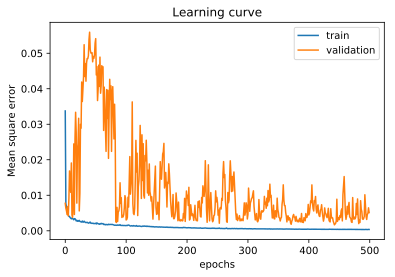

In [44]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Mean square error')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [53]:
preds = velModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

print ("MSE_Loss = " + str(preds[2]))

200/200 [==============================] - 2s 8ms/step

Loss = 0.013295830823481083
Test Accuracy = 0.97
MSE_Loss = 0.013295830823481083


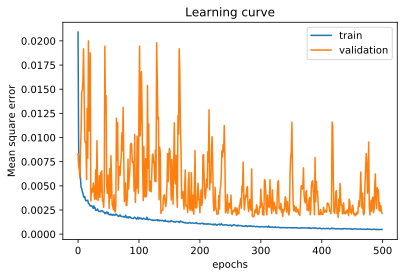

In [46]:
# Plotting the learning curve 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Mean square error')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

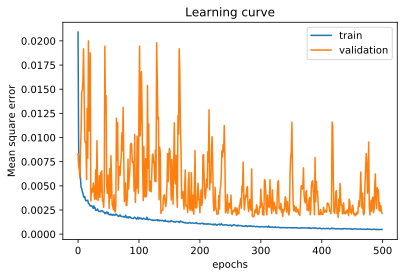

In [47]:
# Plotting the learning curve 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Mean square error')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

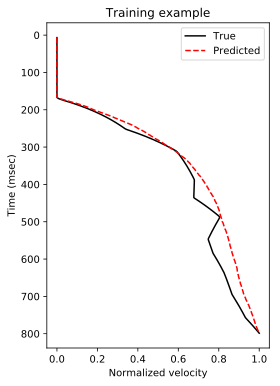

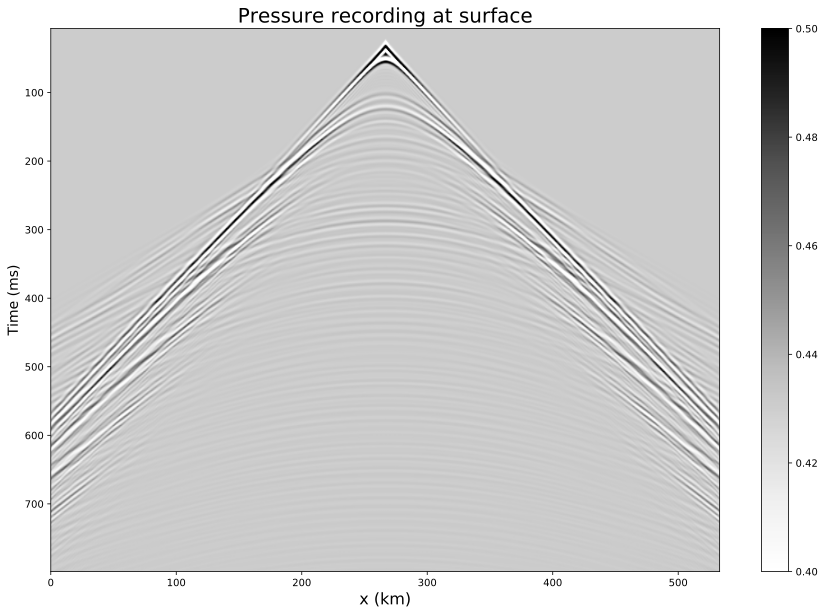

In [49]:
# Plot some of the training examples - true vs trained
sample_number = 41
X_train_sample = X_train[sample_number,:,:,:]
X_train_sample = np.expand_dims(X_train_sample, axis=0)
Y_train_sample = Y_train[sample_number,:]
Y_train_sample_predict = velModel.predict(X_train_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, = plt.plot(Y_train_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_train_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.xlabel('Normalized velocity')
plt.ylabel('Time (msec)')
plt.title('Training example')
plt.gca().invert_yaxis()
# plt.savefig('./Figures/training_example_velocity_08Dec.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_train[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
# plt.savefig('./Figures/training_example_seismic_08Dec.png', bbox_inches='tight')

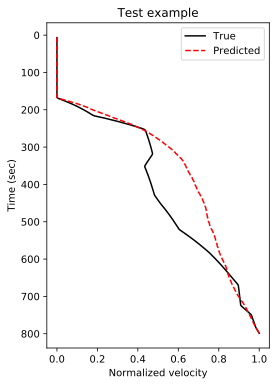

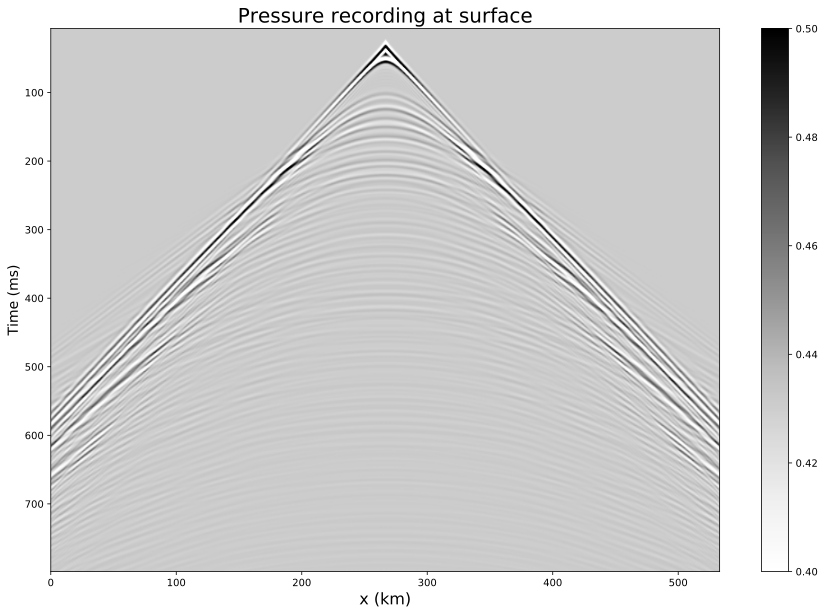

In [51]:
# Plot some of test examples
sample_number = 11 # 4, 40, 15, 25, 33
X_test_sample = X_test[sample_number,:,:,:]
X_test_sample = np.expand_dims(X_test_sample, axis=0)
Y_test_sample = Y_test[sample_number,:]
Y_test_sample_predict = velModel.predict(X_test_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, =plt.plot(Y_test_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_test_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.title('Test example')
plt.xlabel('Normalized velocity')
plt.ylabel('Time (sec)')
plt.gca().invert_yaxis()
# plt.savefig('Figures/test_example_velocity_08Dec_1.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_test[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
# plt.savefig('Figures/test_example_seismic_08Dec_1.png', bbox_inches='tight')